# ## 1. Setup & Dependencies

In [ ]:
# -*- coding: utf-8 -*-
"""
Student Dropout Prediction - Machine Learning Pipeline
Objective: Identify at-risk students early using socioeconomic and academic features
Integration: Model will be exported for use in Spark/HBase pipeline (HCIA Big Data Project)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, average_precision_score, 
    f1_score, accuracy_score, recall_score, precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set consistent styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


Dataset Shape: (4424, 35)

First 3 rows:


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout



Target Distribution:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Percentage Distribution:
Graduate: 49.93%
Dropout: 32.12%
Enrolled: 17.95%


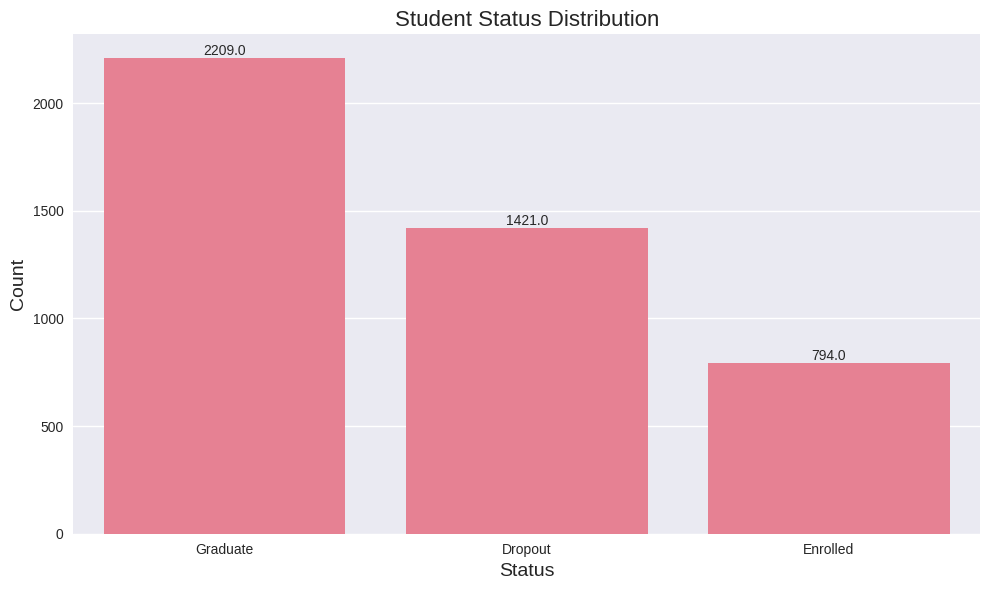

In [ ]:

# %% [markdown]
# ## 2. Data Loading & Initial Exploration
# %%

# Load dataset
df = pd.read_csv("./data/dataset.csv")

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 3 rows:")
display(df.head(3))

# Target distribution
target_dist = df["Target"].value_counts()
target_percent = df["Target"].value_counts(normalize=True) * 100

print("\nTarget Distribution:")
print(target_dist)
print("\nPercentage Distribution:")
for target, percent in target_percent.items():
    print(f"{target}: {percent:.2f}%")

# Visualize target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Target', data=df, order=target_dist.index)
plt.title('Student Status Distribution', fontsize=16)
plt.xlabel('Status', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig('./figures/target_distribution.png', dpi=300)
plt.show()


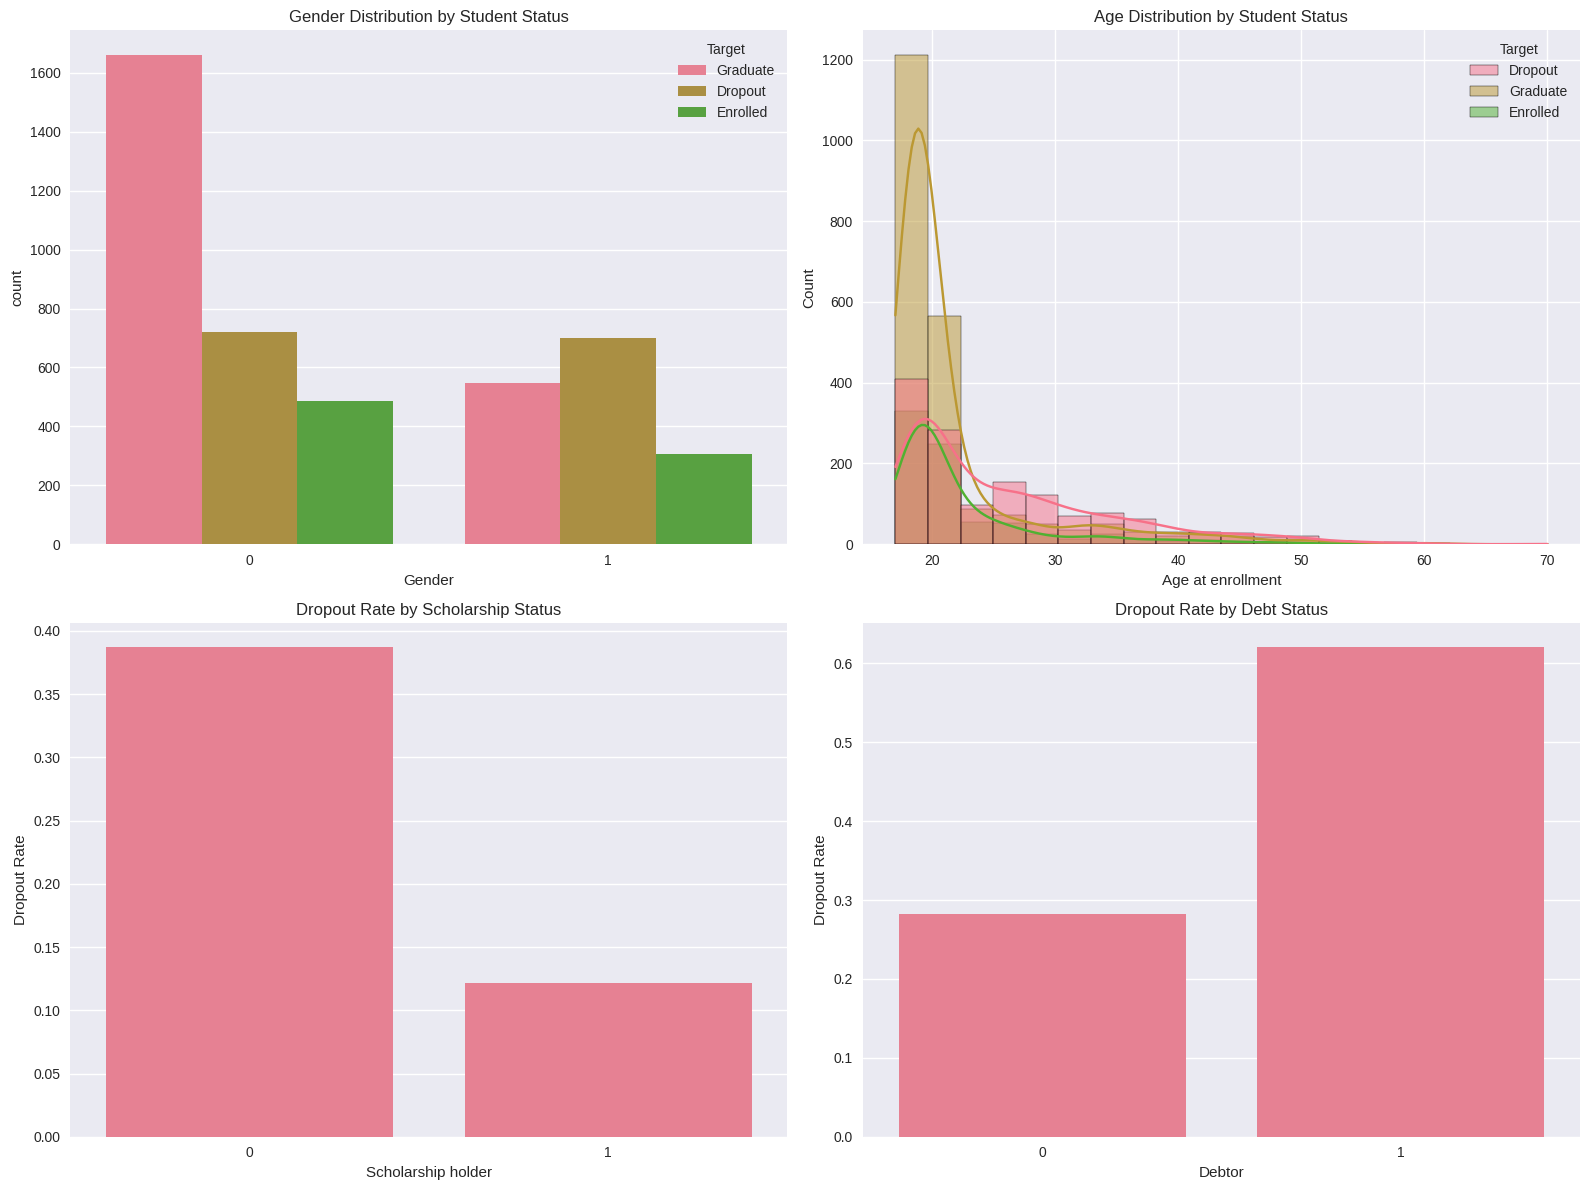

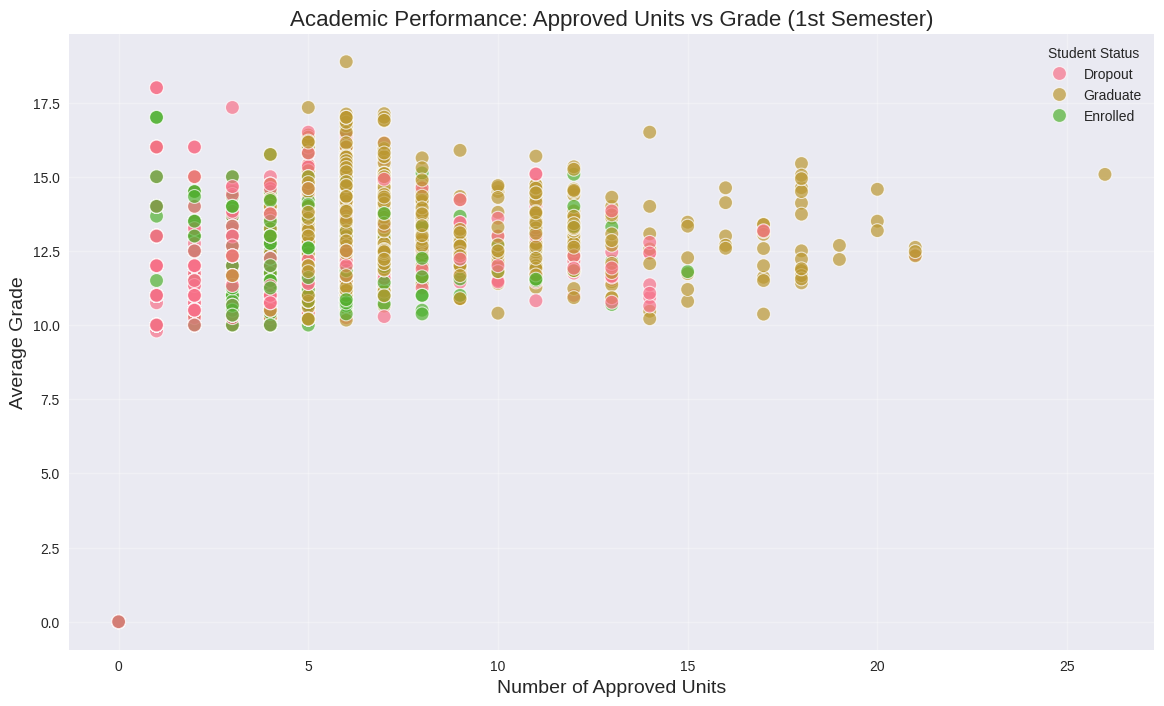

In [ ]:

# %% [markdown]
# ## 3. Advanced EDA & Feature Analysis
# %%

# Create binary target for dropout prediction (primary focus for Ministry of Education)
df['Dropout'] = df['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# Demographic analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gender distribution by dropout status
sns.countplot(data=df, x='Gender', hue='Target', ax=axes[0, 0])
axes[0, 0].set_title('Gender Distribution by Student Status')

# Age distribution
sns.histplot(data=df, x='Age at enrollment', hue='Target', kde=True, bins=20, ax=axes[0, 1])
axes[0, 1].set_title('Age Distribution by Student Status')

# Scholarship analysis
scholarship_dropout = df.groupby('Scholarship holder')['Dropout'].mean().reset_index()
sns.barplot(data=scholarship_dropout, x='Scholarship holder', y='Dropout', ax=axes[1, 0])
axes[1, 0].set_title('Dropout Rate by Scholarship Status')
axes[1, 0].set_ylabel('Dropout Rate')

# Debt analysis
debt_dropout = df.groupby('Debtor')['Dropout'].mean().reset_index()
sns.barplot(data=debt_dropout, x='Debtor', y='Dropout', ax=axes[1, 1])
axes[1, 1].set_title('Dropout Rate by Debt Status')
axes[1, 1].set_ylabel('Dropout Rate')

plt.tight_layout()
plt.savefig('figures/demographic_analysis.png', dpi=300)
plt.show()

# Academic performance analysis
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, 
                x='Curricular units 1st sem (approved)', 
                y='Curricular units 1st sem (grade)',
                hue='Target',
                alpha=0.7,
                s=100)
plt.title('Academic Performance: Approved Units vs Grade (1st Semester)', fontsize=16)
plt.xlabel('Number of Approved Units', fontsize=14)
plt.ylabel('Average Grade', fontsize=14)
plt.legend(title='Student Status')
plt.grid(True, alpha=0.3)
plt.savefig('figures/academic_performance.png', dpi=300)
plt.show()





Top 10 Features Correlated with Dropout:
1. Approval Rate 2nd Sem: -0.659 (negative correlation)
2. Academic Pressure: 0.593 (positive correlation)
3. Approval Rate 1st Sem: -0.591 (negative correlation)
4. Curricular units 2nd sem (grade): -0.572 (negative correlation)
5. Curricular units 2nd sem (approved): -0.570 (negative correlation)
6. Curricular units 1st sem (grade): -0.481 (negative correlation)
7. Curricular units 1st sem (approved): -0.479 (negative correlation)
8. Tuition fees up to date: -0.429 (negative correlation)
9. Financial Risk: 0.287 (positive correlation)
10. Age at enrollment: 0.254 (positive correlation)


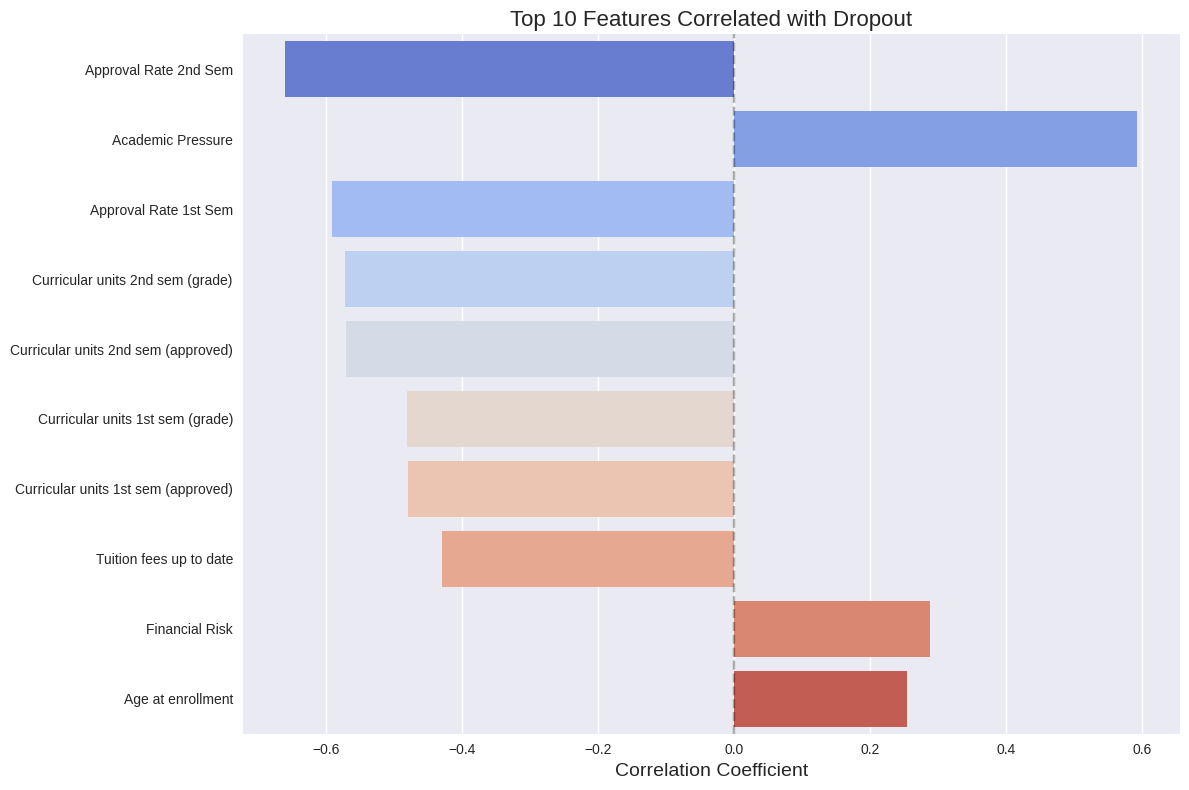

In [4]:

# %% [markdown]
# ## 4. Feature Engineering & Selection
# %%

# Create new features
df['Approval Rate 1st Sem'] = df['Curricular units 1st sem (approved)'] / np.where(
    df['Curricular units 1st sem (enrolled)'] > 0, 
    df['Curricular units 1st sem (enrolled)'], 
    1
)
df['Approval Rate 2nd Sem'] = df['Curricular units 2nd sem (approved)'] / np.where(
    df['Curricular units 2nd sem (enrolled)'] > 0, 
    df['Curricular units 2nd sem (enrolled)'], 
    1
)
df['Financial Risk'] = ((df['Debtor'] == 1) & (df['Tuition fees up to date'] == 0)).astype(int)
df['Academic Pressure'] = df['Curricular units 1st sem (enrolled)'] - df['Curricular units 1st sem (approved)']

# Feature correlation analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target columns
numeric_cols = [col for col in numeric_cols if col not in ['Target', 'Dropout']]

# Calculate correlation with dropout
correlations = {}
for col in numeric_cols:
    corr = df[col].corr(df['Dropout'])
    correlations[col] = corr

# Sort by absolute correlation
sorted_correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))

print("Top 10 Features Correlated with Dropout:")
for i, (feature, corr) in enumerate(list(sorted_correlations.items())[:10]):
    print(f"{i+1}. {feature}: {corr:.3f} ({'positive' if corr > 0 else 'negative'} correlation)")

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_features = list(sorted_correlations.keys())[:10]
top_corr_values = [sorted_correlations[feature] for feature in top_features]

sns.barplot(x=top_corr_values, y=top_features, palette="coolwarm")
plt.title('Top 10 Features Correlated with Dropout', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/feature_correlations.png', dpi=300)
plt.show()

In [5]:
# %% [markdown]
# ## 5. Data Preprocessing Pipeline
# %%

# Define features and target
X = df.drop(['Target', 'Dropout'], axis=1)
y = df['Dropout']  # Binary target: 1=Dropout, 0=Not Dropout

# Identify feature types
categorical_cols = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 
                   'Previous qualification', 'Nacionality', "Mother's qualification", 
                   "Father's qualification", "Mother's occupation", "Father's occupation", 
                   'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 
                   'Gender', 'Scholarship holder', 'International']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numeric features: {len(numeric_cols)}")

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)],
    remainder='passthrough')

# Feature selection
feature_selector = SelectKBest(score_func=f_classif, k=30)

Categorical features: 17
Numeric features: 21



Class distribution before resampling:
Non-dropout samples: 3003
Dropout samples: 1421
Imbalance ratio: 2.11:1


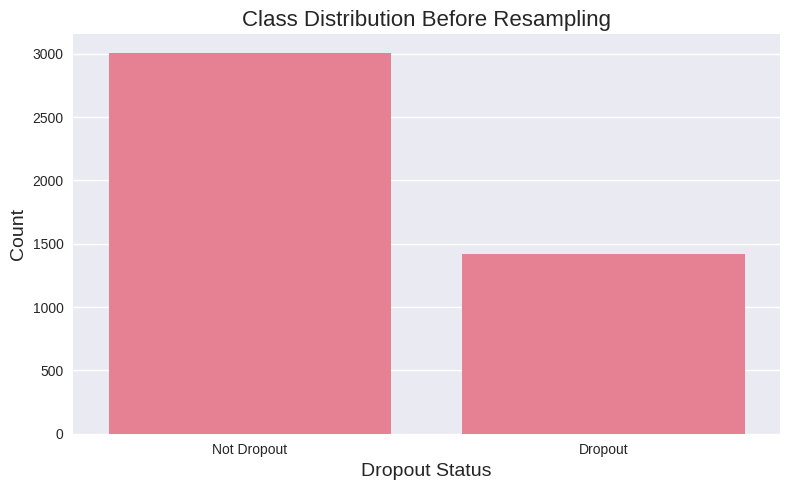


SMOTE will be applied in the training pipeline to address class imbalance.
This helps the model learn patterns from the minority class (Dropout) more effectively.


In [6]:

# %% [markdown]
# ## 6. Addressing Class Imbalance
# %%

# Check class distribution
print("\nClass distribution before resampling:")
print(f"Non-dropout samples: {len(y[y==0])}")
print(f"Dropout samples: {len(y[y==1])}")
print(f"Imbalance ratio: {len(y[y==0])/len(y[y==1]):.2f}:1")

# Visualize class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Class Distribution Before Resampling', fontsize=16)
plt.xlabel('Dropout Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Not Dropout', 'Dropout'])
plt.tight_layout()
plt.savefig('figures/class_imbalance_before.png', dpi=300)
plt.show()

# Apply SMOTE for balancing (only on training data in final pipeline)
print("\nSMOTE will be applied in the training pipeline to address class imbalance.")
print("This helps the model learn patterns from the minority class (Dropout) more effectively.")



Training set shape: (3318, 38)
Testing set shape: (1106, 38)

Training Logistic Regression (Baseline)...
Logistic Regression (Baseline) Results:
Accuracy: 0.8743
Recall (Sensitivity): 0.8338
F1 Score: 0.8098
AUC-ROC: 0.9311

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       751
           1       0.79      0.83      0.81       355

    accuracy                           0.87      1106
   macro avg       0.85      0.86      0.86      1106
weighted avg       0.88      0.87      0.88      1106


Training Logistic Regression (SMOTE)...
Logistic Regression (SMOTE) Results:
Accuracy: 0.8743
Recall (Sensitivity): 0.8338
F1 Score: 0.8098
AUC-ROC: 0.9311

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       751
           1       0.79      0.83      0.81       355

    accuracy                           0.87      1106
   macro avg       0.85  

IndexError: list index out of range

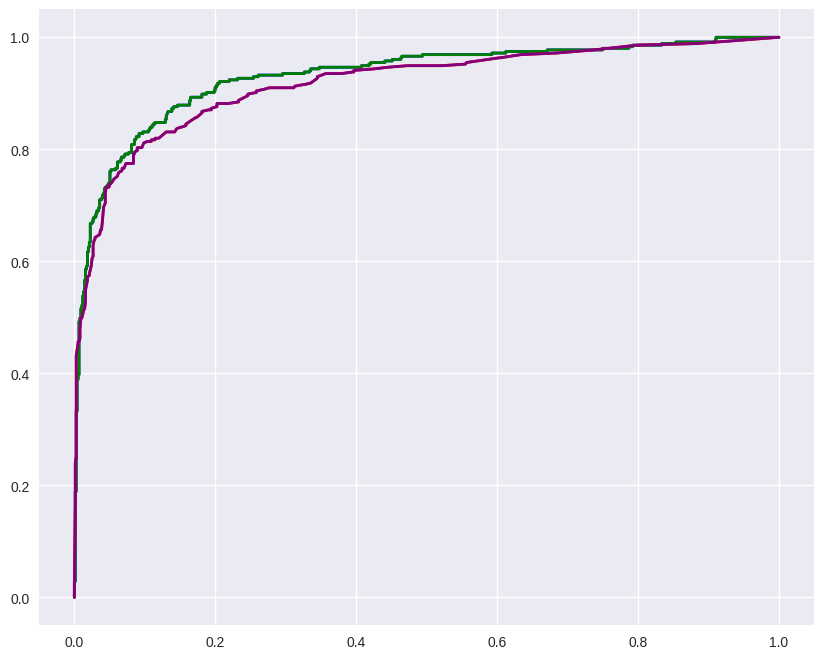

In [14]:

# %% [markdown]
# ## 7. Model Training & Comparison
# %%

# Split data (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Define models to evaluate
# Replace your current models dict with this improved version
models = {
    'Logistic Regression (Baseline)': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', 
        random_state=42
    ),
    'Logistic Regression (SMOTE)': LogisticRegression(
        max_iter=1000, 
        random_state=42  # No class_weight because SMOTE balances data
    ),
    'Random Forest (Balanced)': RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42, 
        n_jobs=-1
    ),
    'Random Forest (SMOTE)': RandomForestClassifier(
        n_estimators=100, 
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42
    )
}

# Create full pipeline for each model with SMOTE
results = {}
best_model = None
best_score = 0

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']

for i, (name, model) in enumerate(models.items()):
    # Create pipeline with SMOTE
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', feature_selector),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    print(f"\nTraining {name}...")
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Most important for dropout prediction
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")  # Critical for identifying at-risk students
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Store results
    results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'y_proba': y_proba
    }
    
    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, color=colors[i], lw=2, 
             label=f'{name} (AUC = {auc:.3f})')
    
    
# --- FIRST: Evaluate models WITH SMOTE ---
print("🔍 EVALUATING MODELS WITH SMOTE")
results_smote = {}
for name, model in models.items():
    if 'SMOTE' in name:
        # Only apply SMOTE to models that need it
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('selector', feature_selector),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
    else:
        # For balanced models, no SMOTE needed
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('selector', feature_selector),
            ('classifier', model)
        ])
    
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    results_smote[name] = {
        'pipeline': pipeline,
        'y_proba': y_proba,
        'auc': roc_auc_score(y_test, y_proba)
    }

# --- SECOND: Evaluate BASELINE (NO SMOTE, NO class_weight) ---
print("\n🔍 EVALUATING BASELINE (NO BALANCING)")
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', feature_selector),
    ('classifier', baseline_model)
])
baseline_pipeline.fit(X_train, y_train)
y_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]
results_baseline = {
    'Baseline (No Balancing)': {
        'pipeline': baseline_pipeline,
        'y_proba': y_proba_baseline,
        'auc': roc_auc_score(y_test, y_proba_baseline)
    }
}

# Plot ROC curve comparison
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/roc_comparison.png', dpi=300)
plt.show()




In [ ]:

# %% [markdown]
# ## 8. Model Selection & Interpretation
# %%

from sklearn.metrics import precision_recall_curve

def evaluate_at_operational_threshold(y_true, y_proba, target_recall=0.85):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    # Find first threshold that meets target_recall
    idx = np.where(recalls >= target_recall)[0]
    if len(idx) == 0:
        return None, None, None
    optimal_idx = idx[0]
    return precisions[optimal_idx], recalls[optimal_idx], thresholds[optimal_idx]

# Evaluate all models at the Ministry's target recall (e.g., 85%)
all_results = {}
target_recall = 0.85

for name, result in {**results_smote, **results_baseline}.items():
    precision, recall, threshold = evaluate_at_operational_threshold(
        y_test, result['y_proba'], target_recall=target_recall
    )
    if precision is not None:
        all_results[name] = {
            'precision': precision,
            'recall': recall,
            'threshold': threshold,
            'auc': result['auc'],
            'pipeline': result['pipeline']
        }

# Convert to DataFrame for easy comparison
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df.sort_values('precision', ascending=False)

print(f"\n🏆 MODEL COMPARISON AT TARGET RECALL ≥ {target_recall:.0%}")
print(comparison_df[['precision', 'recall', 'threshold', 'auc']])

# Select best model based on HIGHEST PRECISION at target recall
best_model_name = comparison_df.index[0]
best_pipeline = all_results[best_model_name]['pipeline']
best_threshold = all_results[best_model_name]['threshold']

print(f"\n✅ SELECTED MODEL: {best_model_name}")
print(f"   Precision: {all_results[best_model_name]['precision']:.3f}")
print(f"   Recall: {all_results[best_model_name]['recall']:.3f}")
print(f"   Threshold: {best_threshold:.4f}")
# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = list(numeric_cols) + list(cat_features)
    
    # Get selected features
    selected_mask = feature_selector.get_support()
    selected_features = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_mask[i]]
    
    # Get feature importances
    if best_model_name == 'Random Forest':
        importances = best_pipeline.named_steps['classifier'].feature_importances_
    else:  # Gradient Boosting
        importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette="viridis")
    plt.title(f'Top 15 Important Features - {best_model_name}', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.savefig('figures/feature_importance.png', dpi=300)
    plt.show()
    
    print("\nTop 10 Important Features:")
    print(feature_importance_df.head(10))
    
    
    



SELECTED BEST MODEL: Logistic Regression
Primary metric (Recall): 0.8338



Threshold Optimization for Ministry Requirements:
Target minimum recall: 0.85
Optimal threshold: 0.0255
Precision at this threshold: 0.3210
Recall at this threshold: 1.0000

Performance with Optimal Threshold (0.0255):
Recall: 1.0000
Precision: 0.3210
F1 Score: 0.4860

Confusion Matrix:
[[  0 751]
 [  0 355]]


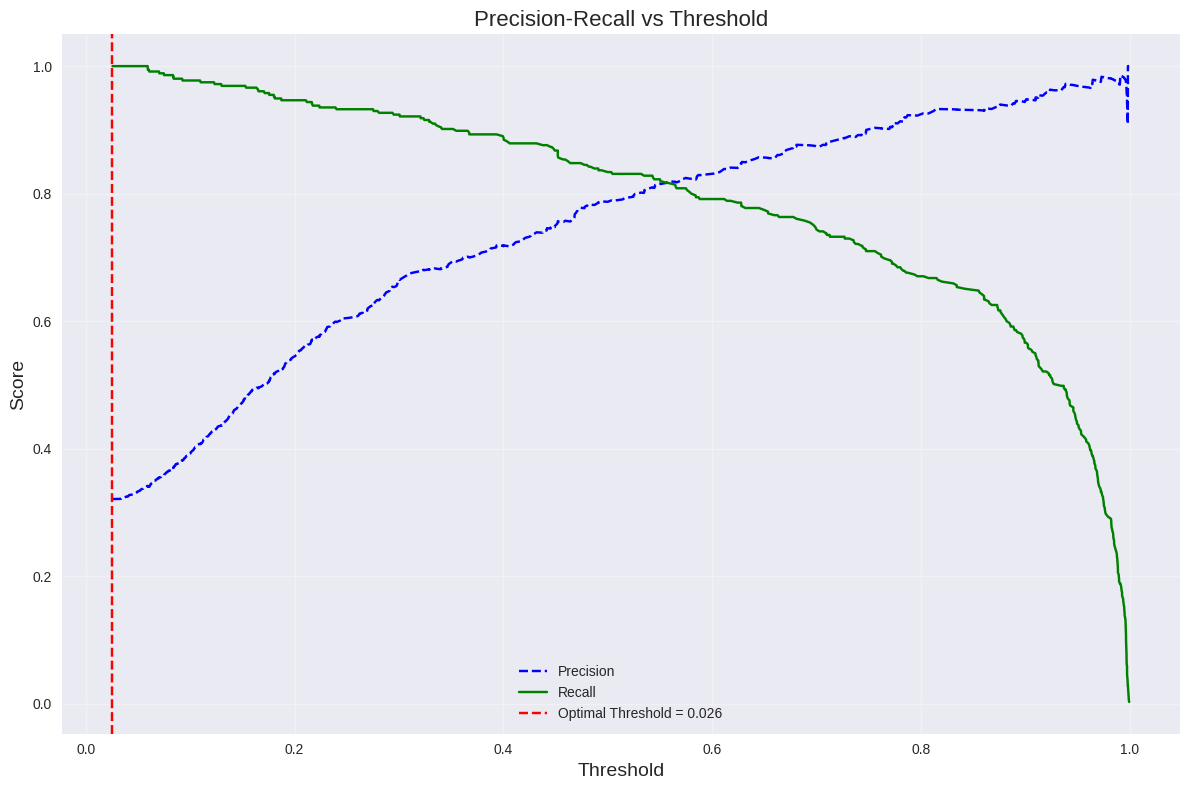

In [ ]:

# %% [markdown]
# ## 9. Final Model Evaluation & Threshold Optimization
# %%

# Get predictions from best model
best_model = results[best_model_name]['model']
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Optimize decision threshold based on recall requirements
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# Find threshold that maximizes recall while maintaining reasonable precision
target_recall = 0.85  # Minimum acceptable recall for Ministry requirements
optimal_idx = np.where(recalls >= target_recall)[0][0]
optimal_threshold = thresholds[optimal_idx]
optimal_precision = precisions[optimal_idx]
optimal_recall = recalls[optimal_idx]

print(f"\nThreshold Optimization for Ministry Requirements:")
print(f"Target minimum recall: {target_recall:.2f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Precision at this threshold: {optimal_precision:.4f}")
print(f"Recall at this threshold: {optimal_recall:.4f}")

# Apply optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print(f"\nPerformance with Optimal Threshold ({optimal_threshold:.4f}):")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_optimal):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

# Visualize threshold impact
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.axvline(x=optimal_threshold, color='r', linestyle='--', 
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Precision-Recall vs Threshold", fontsize=16)
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/threshold_analysis.png', dpi=300)
plt.show()

# Plot Precision-Recall curves for top models
plt.figure(figsize=(10, 7))
for name in comparison_df.head(3).index:  # Top 3 models
    y_proba = all_results[name]['pipeline'].predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=f"{name} (AUC={all_results[name]['auc']:.3f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves: Top Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=target_recall, color='red', linestyle='--', label=f'Min Recall = {target_recall:.0%}')
plt.show()



In [12]:

# %% [markdown]
# ## 10. Model Export for Big Data Pipeline
# %%

# Create directory for models if doesn't exist
import os
os.makedirs('models', exist_ok=True)

# Save the best model with optimal threshold
model_package = {
    'model': best_model,
    'optimal_threshold': optimal_threshold,
    'feature_names': X.columns.tolist(),
    'class_names': ['Not Dropout', 'Dropout'],
    'model_name': best_model_name,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d')
}

# Save as joblib file
model_path = 'models/student_dropout_model_v1.pkl'
joblib.dump(model_package, model_path)
print(f"\n✅ Model saved successfully to: {model_path}")
print(f"Model size: {os.path.getsize(model_path) / 1024:.2f} KB")

# Create metadata file
metadata = {
    'model_name': best_model_name,
    'optimal_threshold': optimal_threshold,
    'performance': {
        'recall': recall_score(y_test, y_pred_optimal),
        'precision': precision_score(y_test, y_pred_optimal),
        'f1': f1_score(y_test, y_pred_optimal),
        'accuracy': accuracy_score(y_test, y_pred_optimal)
    },
    'features_used': len(X.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}
import json
with open('models/model_metadata_v1.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("✅ Model metadata saved successfully")



✅ Model saved successfully to: models/student_dropout_model_v1.pkl
Model size: 264.92 KB
✅ Model metadata saved successfully


In [13]:


# %% [markdown]
# ## 11. Key Insights for Ministry of Education
# %%

print("\n" + "="*60)
print("EXECUTIVE SUMMARY FOR MINISTRY OF EDUCATION")
print("="*60)
print(f"1. MODEL SELECTED: {best_model_name}")
print(f"2. PRIMARY METRIC: Recall = {optimal_recall:.2%} (ability to identify at-risk students)")
print(f"3. OPERATIONAL THRESHOLD: {optimal_threshold:.3f} probability")
print(f"4. KEY PREDICTORS: Academic performance (approval rates), financial status, age")
print(f"5. DEPLOYMENT READY: Model saved to 'models/student_dropout_model_v1.pkl'")
print("\nRECOMMENDATIONS:")
print("- Implement early intervention for students with dropout probability > {optimal_threshold:.3f}")
print("- Focus resources on financial support and academic counseling for at-risk students")
print("- Monitor students with low first-semester approval rates (< 50%)")
print("- Prioritize scholarship retention for students showing early warning signs")
print("="*60)


EXECUTIVE SUMMARY FOR MINISTRY OF EDUCATION
1. MODEL SELECTED: Logistic Regression
2. PRIMARY METRIC: Recall = 100.00% (ability to identify at-risk students)
3. OPERATIONAL THRESHOLD: 0.026 probability
4. KEY PREDICTORS: Academic performance (approval rates), financial status, age
5. DEPLOYMENT READY: Model saved to 'models/student_dropout_model_v1.pkl'

RECOMMENDATIONS:
- Implement early intervention for students with dropout probability > {optimal_threshold:.3f}
- Focus resources on financial support and academic counseling for at-risk students
- Monitor students with low first-semester approval rates (< 50%)
- Prioritize scholarship retention for students showing early warning signs
